Загрузка необходимых для работы библиотек и открытиые файлов

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


Проанализируем имеющиеся данные

In [5]:
print(train_data.head())
print(train_data.info())
print(train_data.describe())


  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   

   ...  EmploymentStatus  EducationLev

Какие то чиселки, непонятно


Узнаем, сколько пропущенных значений в данных

In [6]:
train_data.isnull().sum()

,0
ApplicationDate,530
Age,530
AnnualIncome,530
CreditScore,1031
LoanAmount,1031
LoanDuration,530
MaritalStatus,530
NumberOfDependents,530
HomeOwnershipStatus,530
MonthlyDebtPayments,1031


Ага, есть пропуски, надо будет их убрать потом

Проанализируем распределение RiskScore

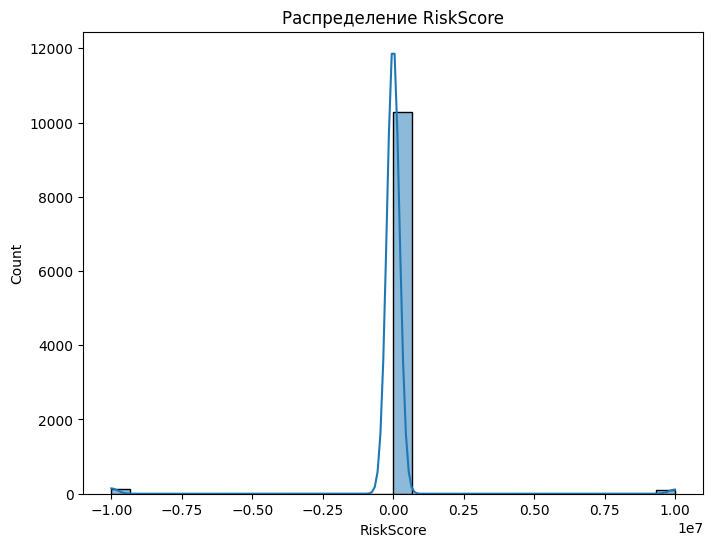

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(train_data['RiskScore'], bins=30, kde=True)
plt.title('Распределение RiskScore')
plt.show()


Можно заметить очевидные выбросы по краям графика, которые при обработке следует не учитывать
В остальном же значения полижтельные и не далеко от 0

Посмотрим на распределения числовых столбцов

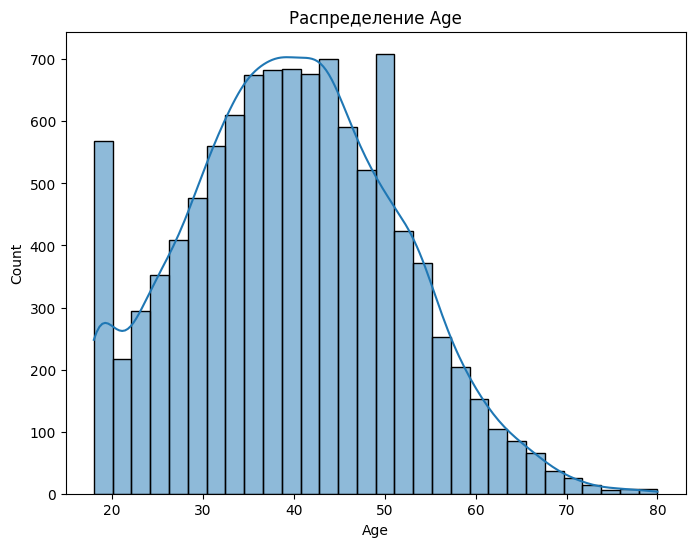

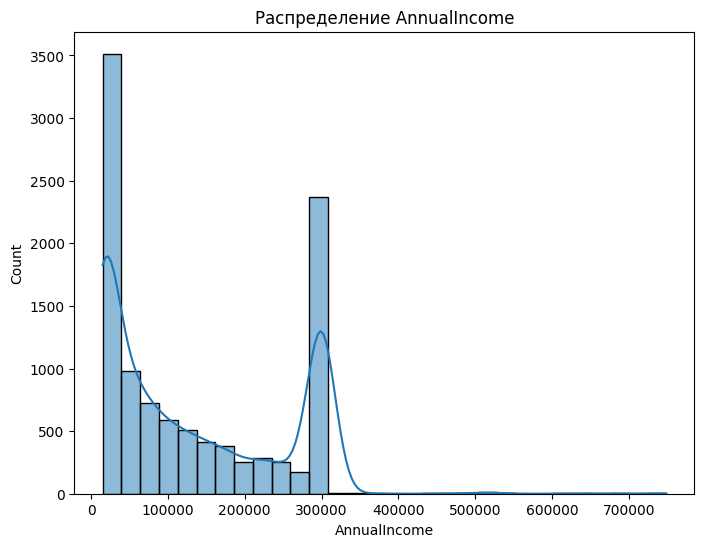

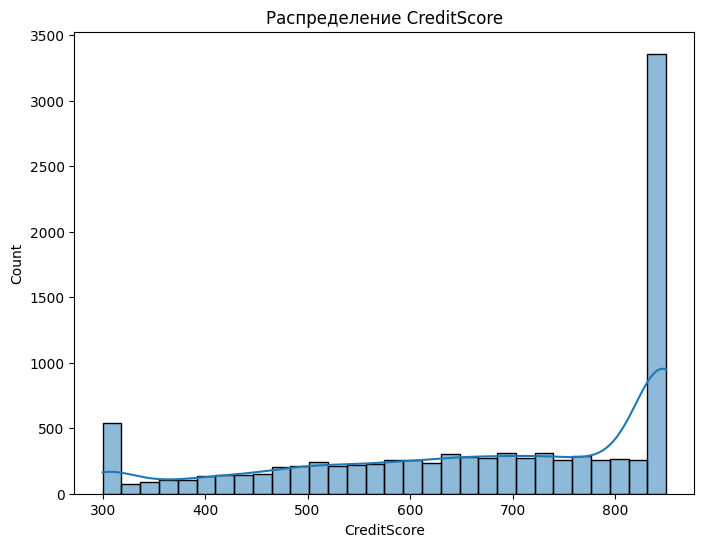

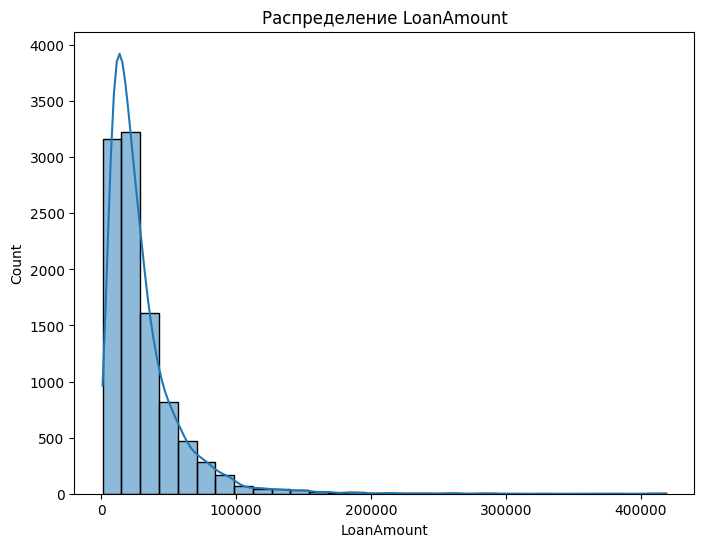

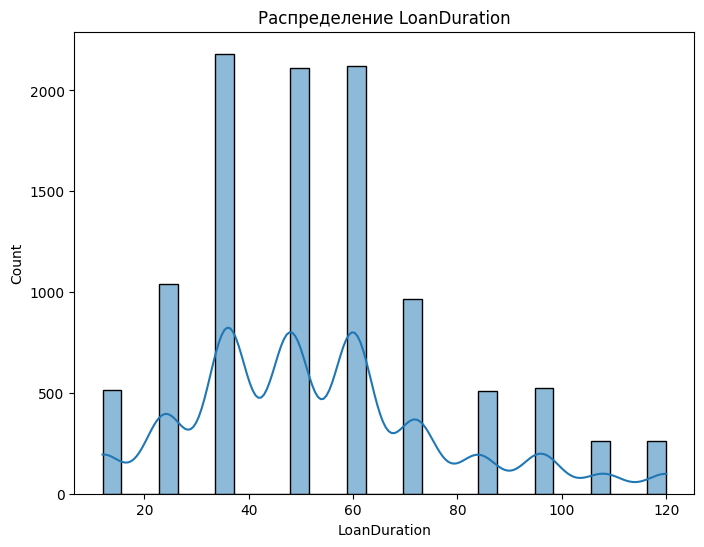

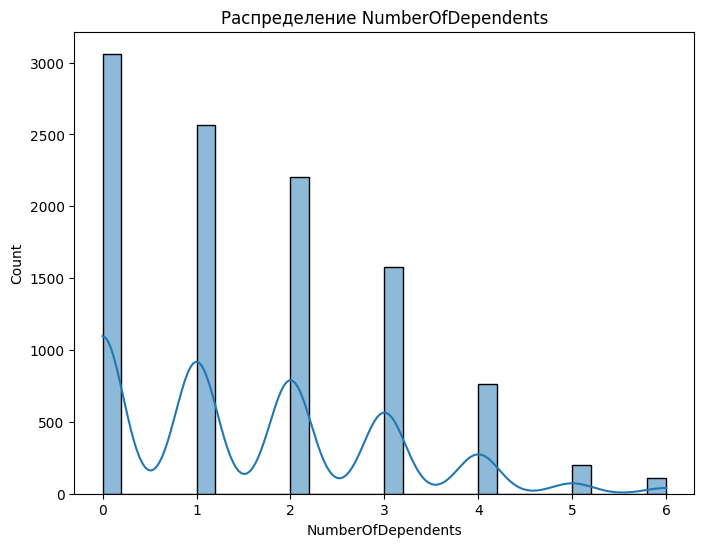

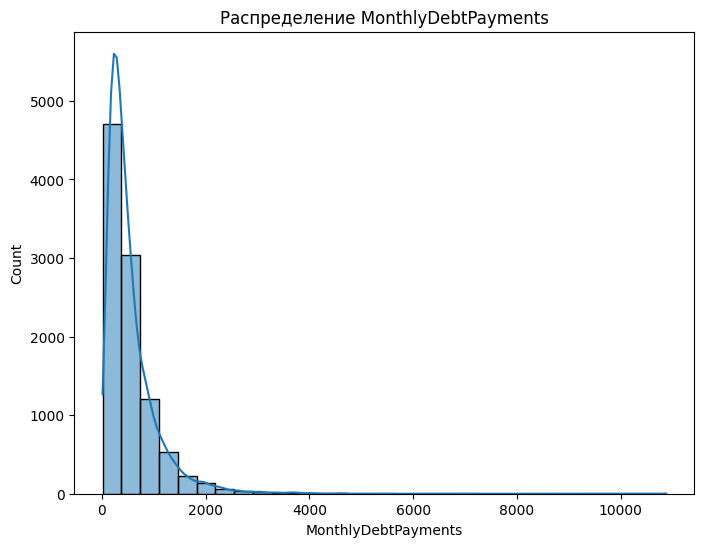

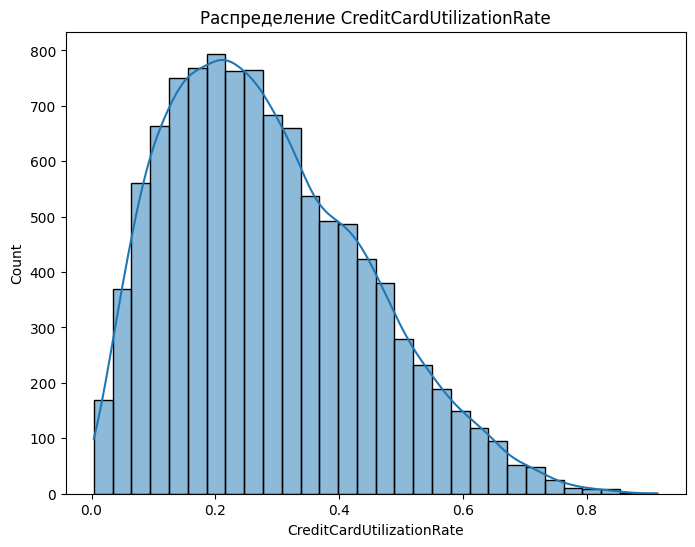

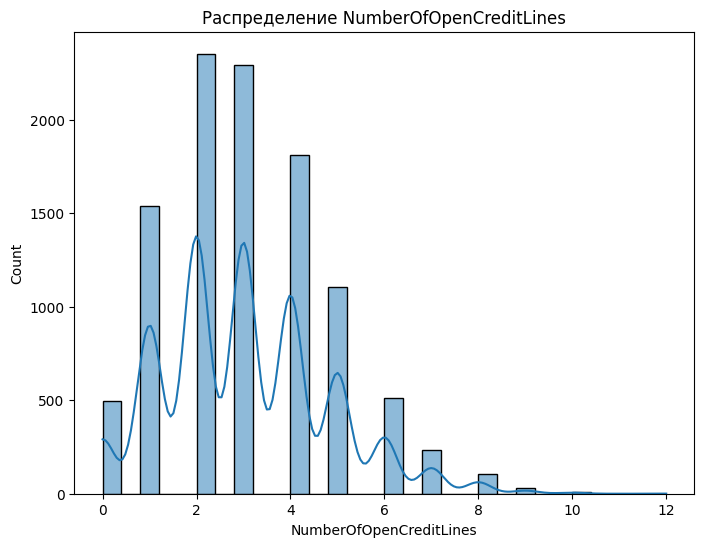

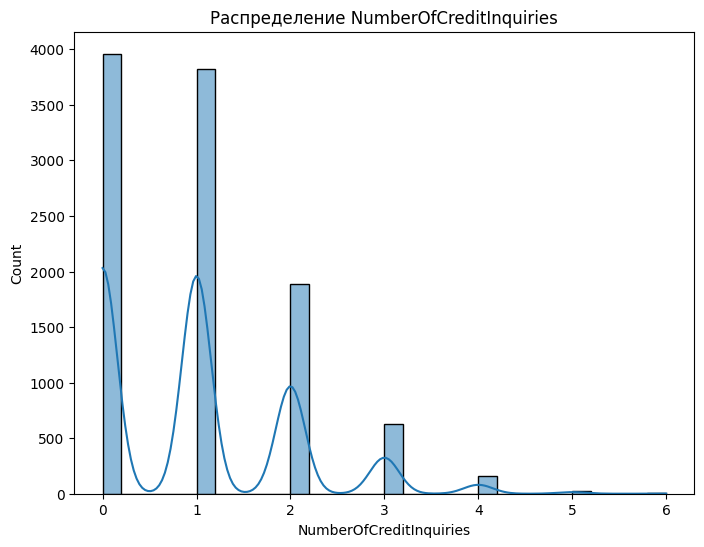

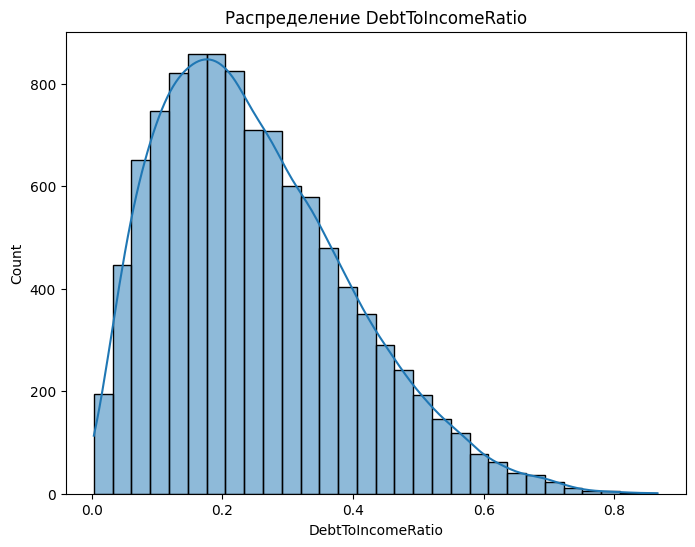

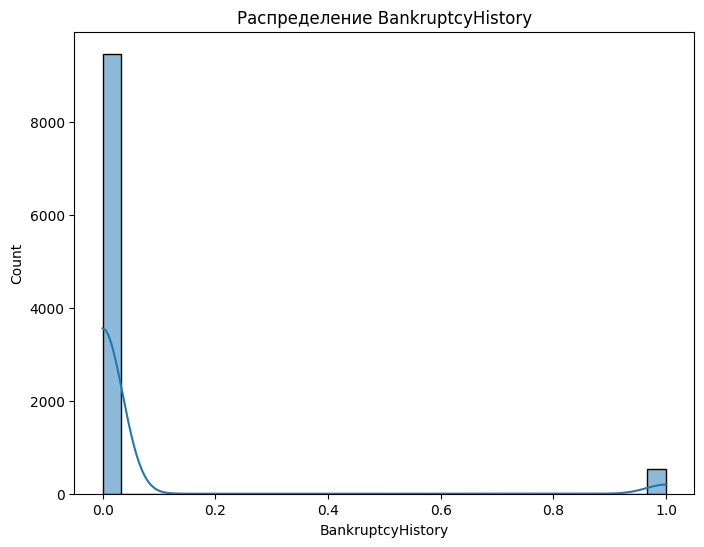

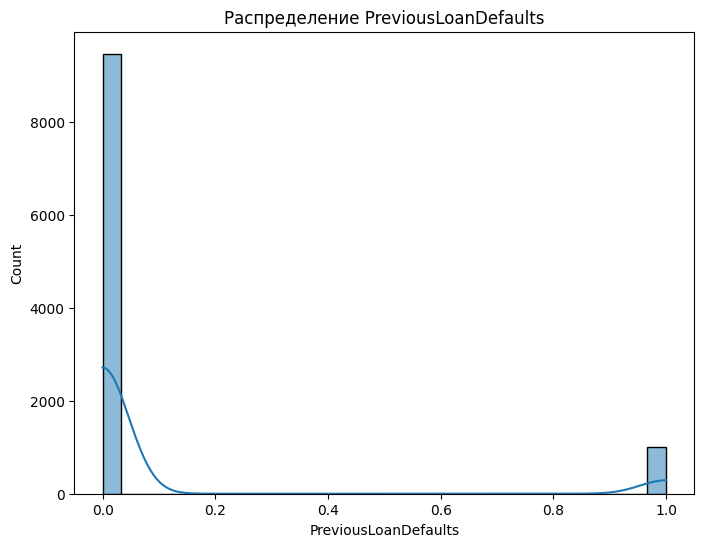

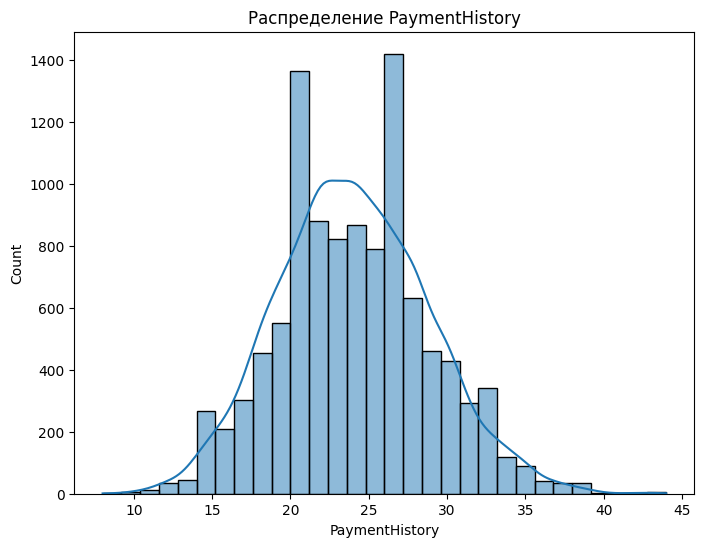

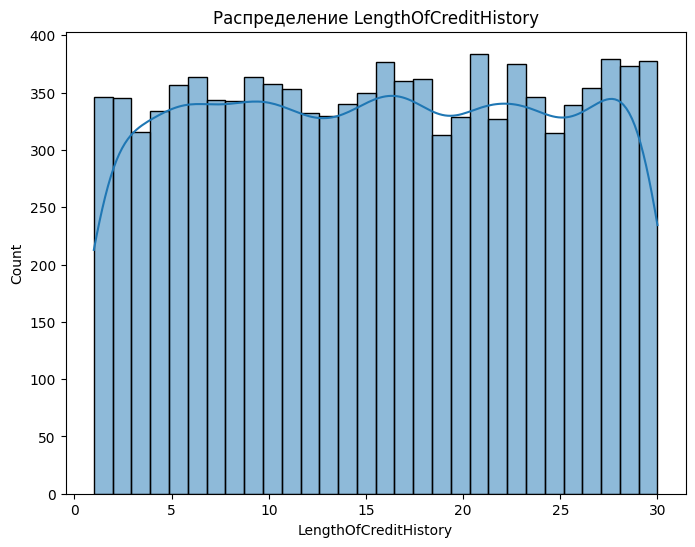

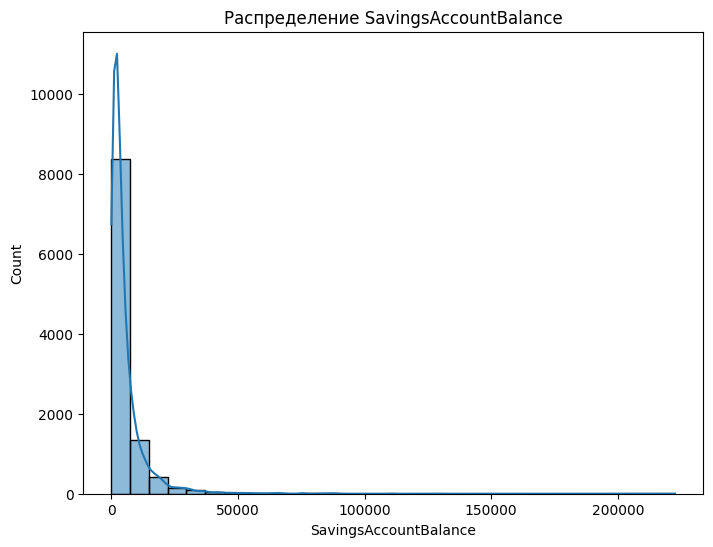

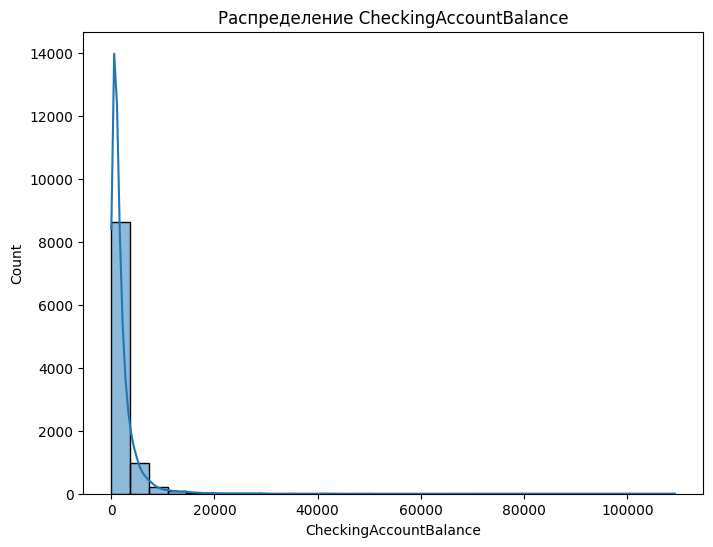

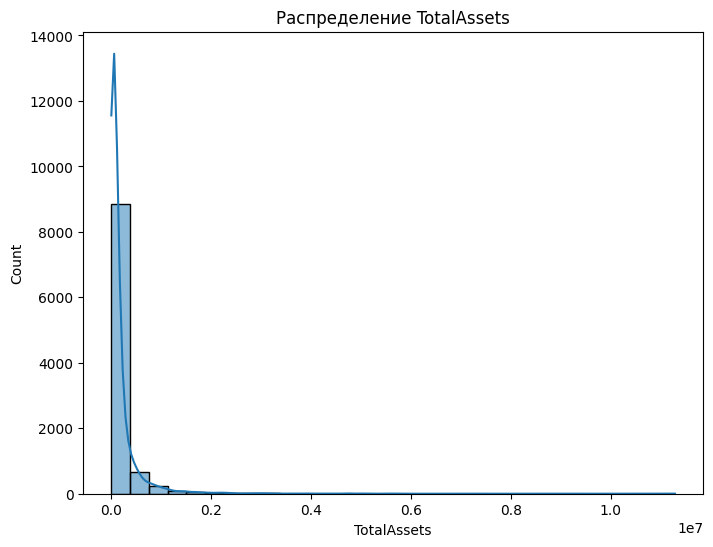

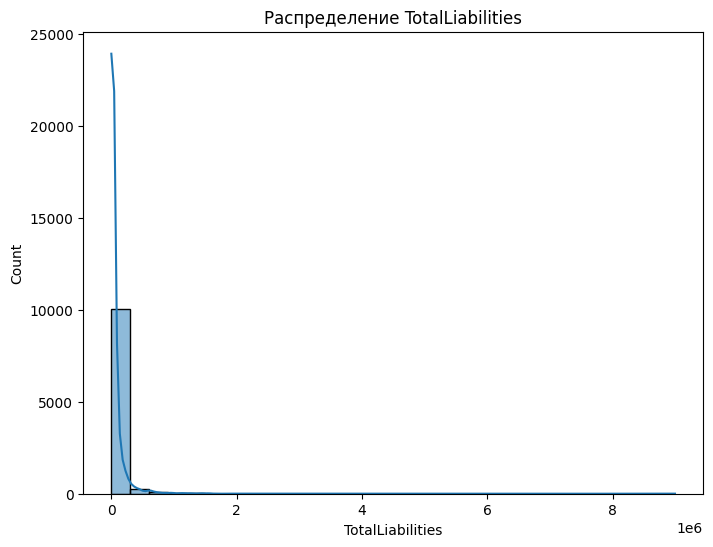

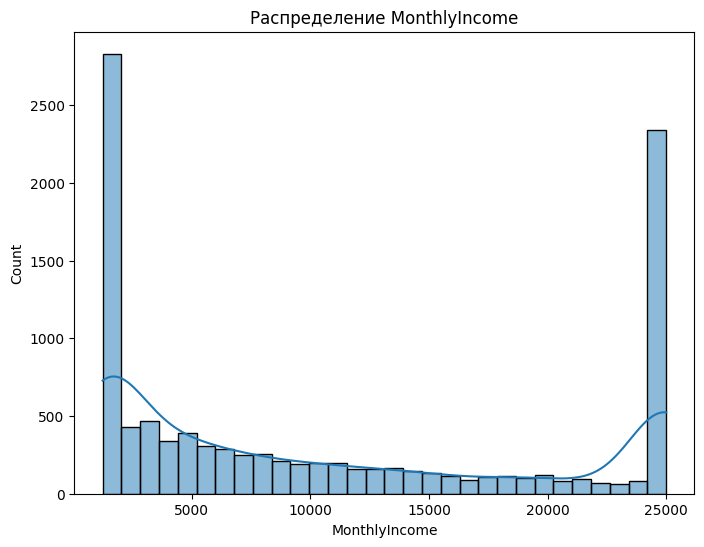

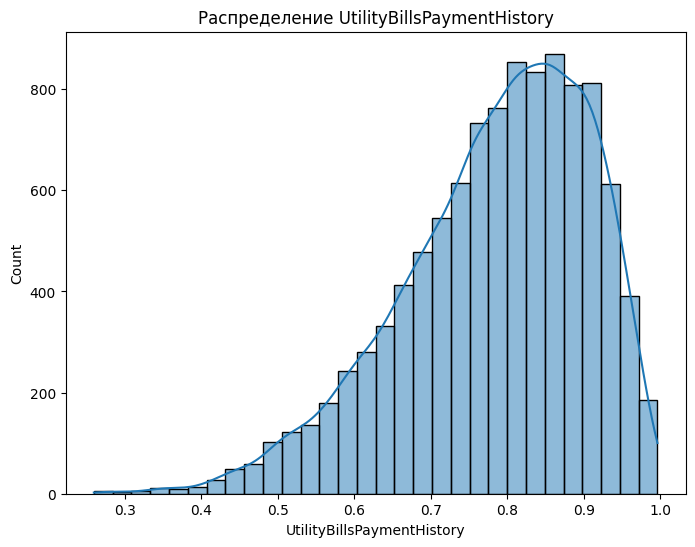

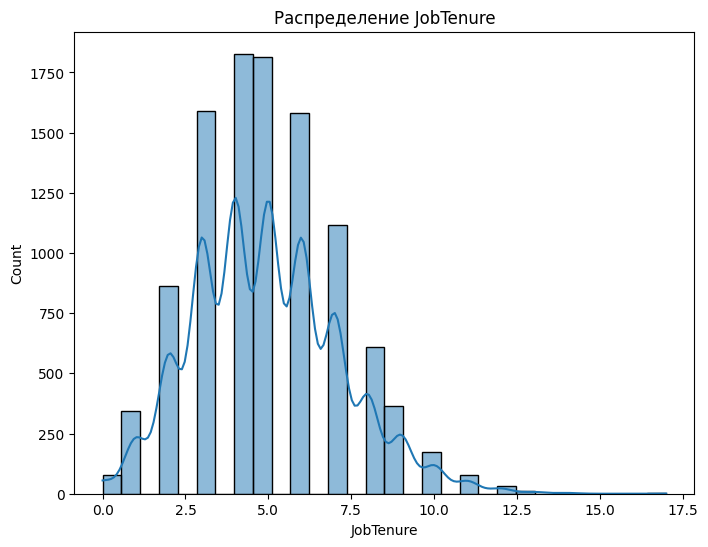

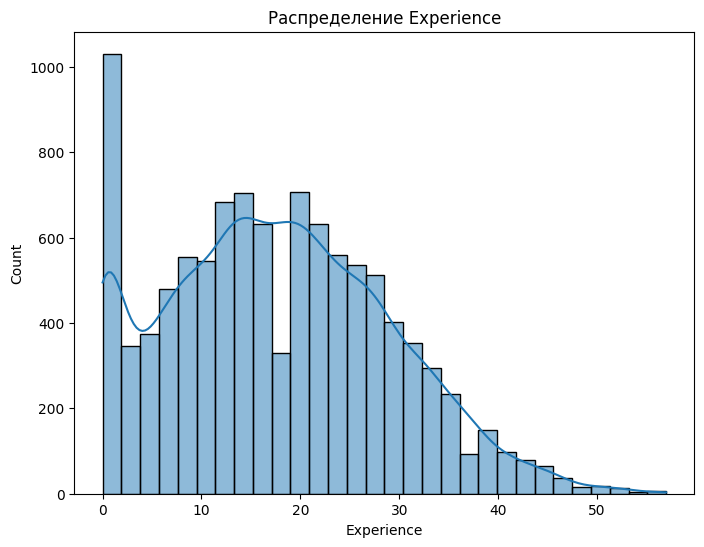

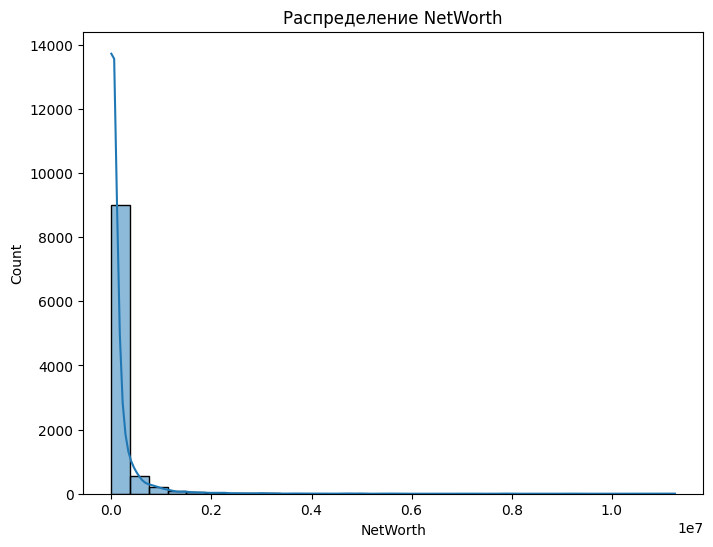

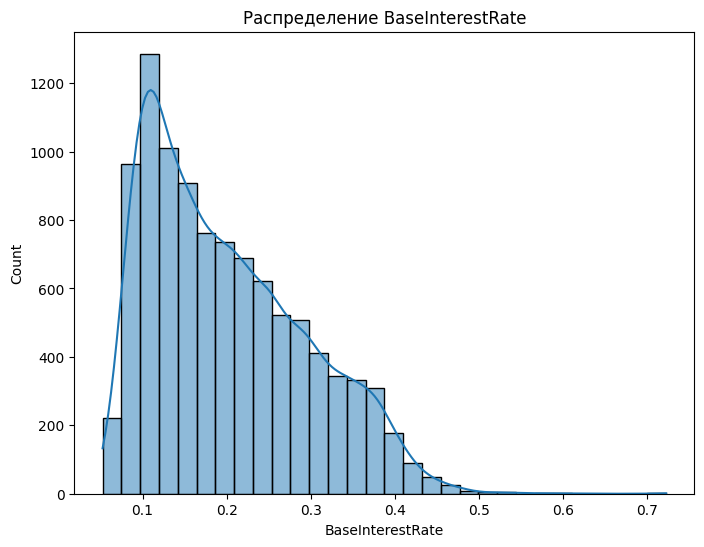

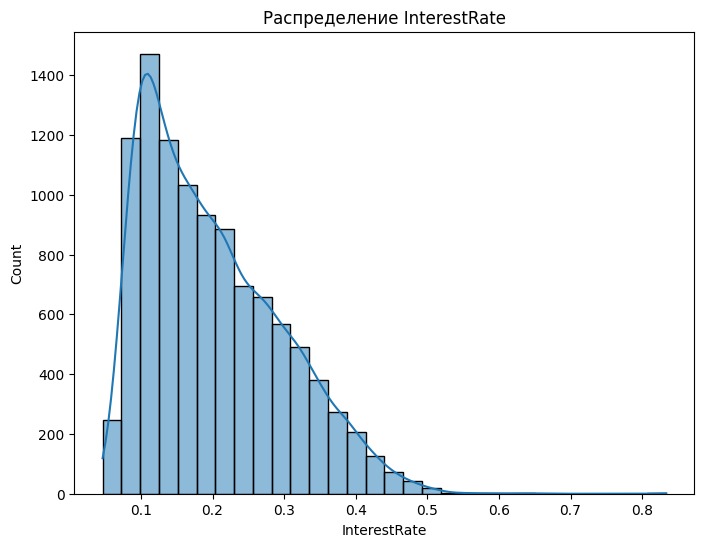

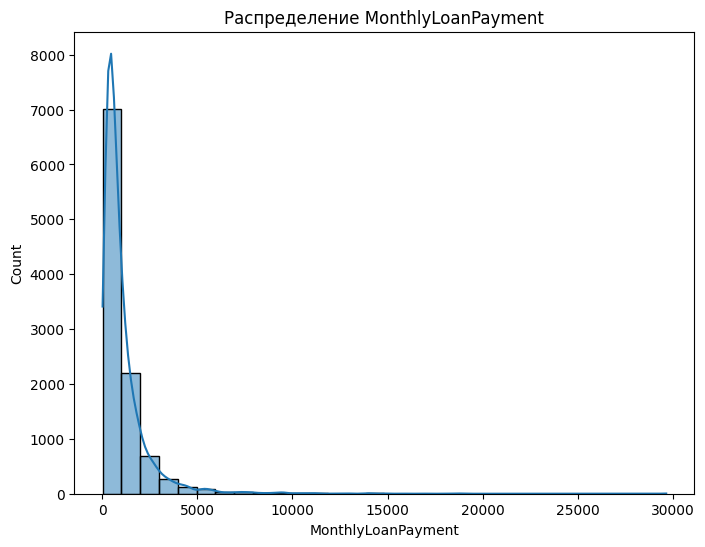

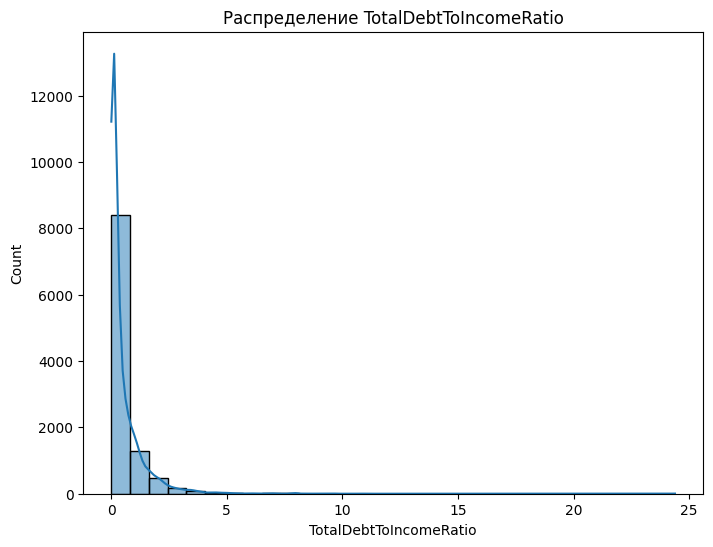

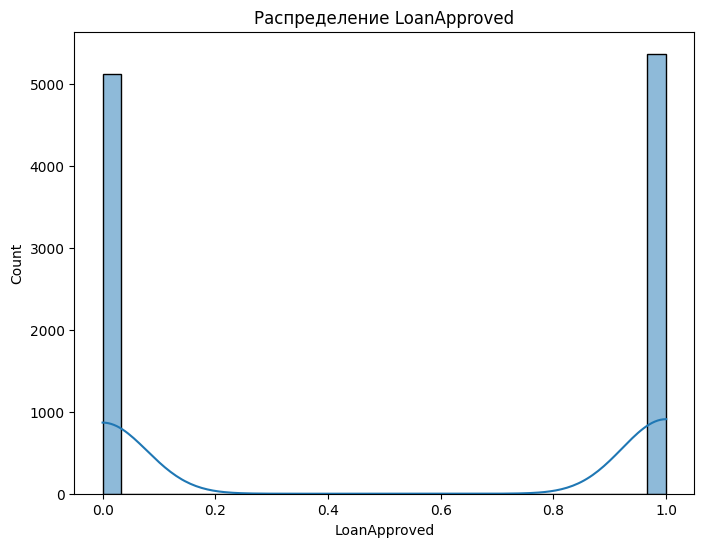

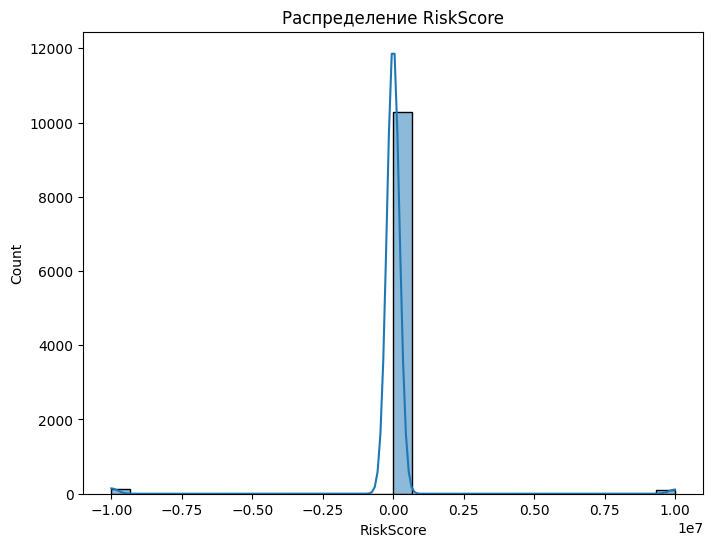

In [7]:
numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_data[feature], bins=30, kde=True)
    plt.title(f'Распределение {feature}')
    plt.show()


С графиком заметны примерные распределения чисел. Также можно оценить величины, представленные в данных, какие нужно будет пронормировать и как

Просмотр категориальных признаков для понимания его содержимого

In [8]:
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

for feature in categorical_features:
    print(f"Уникальные значения в {feature}: {train_data[feature].unique()}")


Уникальные значения в ApplicationDate: ['2010-06-26' '1996-09-23' '2015-01-19' ... '2010-11-07' '2001-12-28' nan]
Уникальные значения в MaritalStatus: ['Divorced' 'Widowed' 'Married' 'Single' nan]
Уникальные значения в HomeOwnershipStatus: ['Rent' 'Mortgage' 'Other' 'Own' nan]
Уникальные значения в LoanPurpose: ['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other' nan]
Уникальные значения в EmploymentStatus: ['Employed' 'Self-Employed' 'Unemployed' nan]
Уникальные значения в EducationLevel: ['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate' nan]


Значение даты нужно будет исключить, так как там в основном будут уникальные значения. В остальном же категорий немного, воспользуемся one-hot encoding


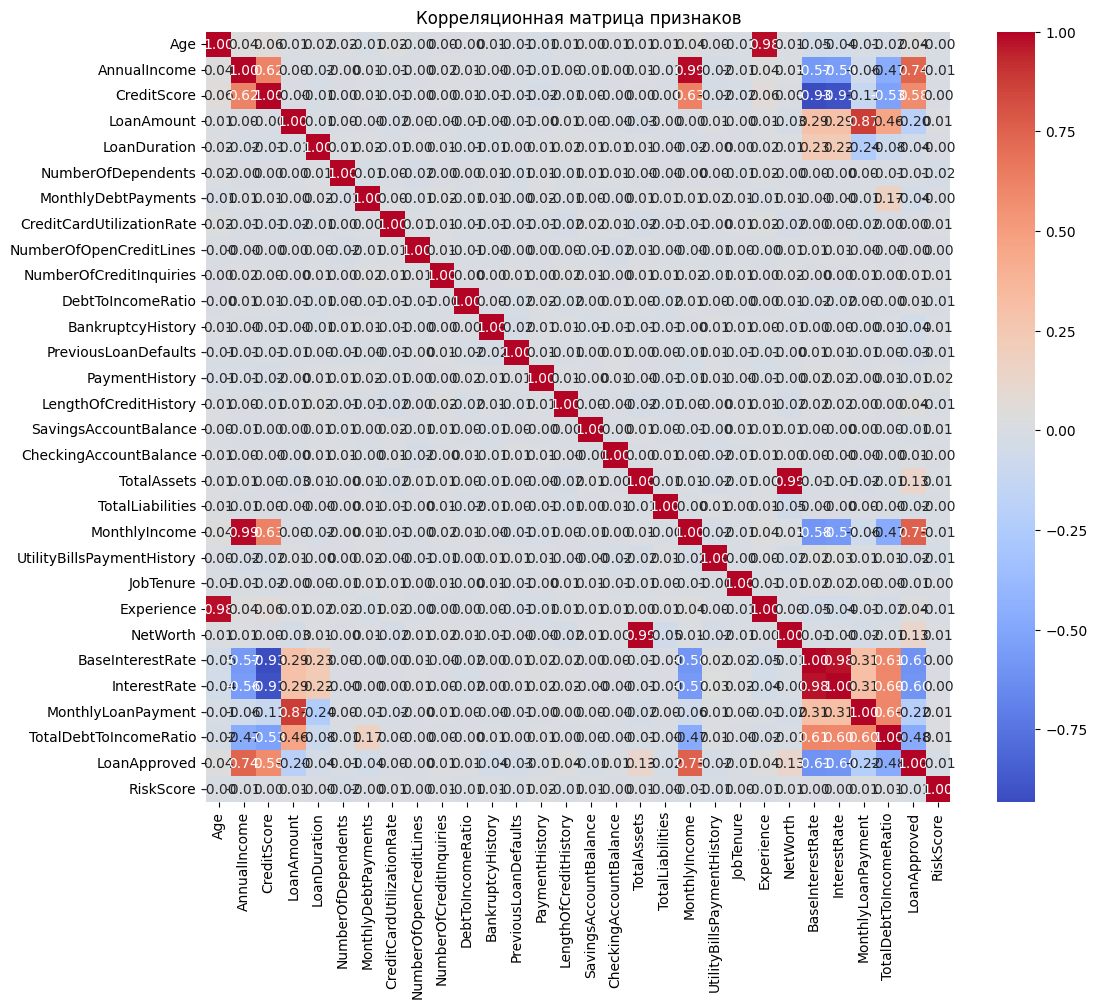

In [ ]:
numeric_features = train_data.select_dtypes(include=[np.number])

corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Корреляционная матрица признаков')
plt.show()


Запомним сильнокоррелирующие признаки, чтобы не давать их модели

Перейдем к обработке данных

In [9]:
def drop_corr(df):
    columns_to_drop = ['Experience', 'MonthlyIncome', 'LoanApproved', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalAssets']
    return df.drop(columns=columns_to_drop)

Уберем эти призначи, так как они будут учтены в других признаках

In [10]:
def encode_categorical(df):
    categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'EmploymentStatus', 'EducationLevel', 'LoanPurpose']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df


Разобьем категориальные признаки

In [11]:
def normalize_features(df):
    standardize_cols = ['Age', 'LoanDuration', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'DebtToIncomeRatio',
                        'PaymentHistory', 'UtilityBillsPaymentHistory', 'JobTenure']
    minmax_cols = ['CreditScore', 'NumberOfDependents', 'LengthOfCreditHistory']
    log_transform_cols = ['AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments', 'NumberOfCreditInquiries', 'SavingsAccountBalance',
                          'CheckingAccountBalance', 'TotalLiabilities', 'NetWorth', 'TotalDebtToIncomeRatio']

    scaler_standard = StandardScaler()
    df[standardize_cols] = scaler_standard.fit_transform(df[standardize_cols])

    scaler_minmax = MinMaxScaler()
    df[minmax_cols] = scaler_minmax.fit_transform(df[minmax_cols])

    df[log_transform_cols] = np.log1p(df[log_transform_cols])
    df[log_transform_cols] = scaler_standard.fit_transform(df[log_transform_cols])

    return df


По графику выше произведем соответсвующие нормализации данных

In [12]:
def handle_missing_outliers(df, is_train=True):
    df = df.fillna(df.median())
    df[df.select_dtypes(include=[bool]).columns] = df.select_dtypes(include=[bool]).astype(int)
    df = df.drop_duplicates()
    if is_train:
        df = df[(df['RiskScore'] >= -1000) & (df['RiskScore'] <= 1000)]
    return df


Уберём выбросы

In [13]:
def process_data(df, is_train=True):
    df = drop_corr(df)
    df = encode_categorical(df)
    df = normalize_features(df)
    df = handle_missing_outliers(df, is_train)
    return df


Применим обработку и обучим модель

In [14]:
train_data = train_data.drop(columns=['ApplicationDate'])
test_data = test_data.drop(columns=['ApplicationDate'])

train_data_processed = process_data(train_data)
test_data_processed = process_data(test_data, is_train=False)

X = train_data_processed.drop(columns=['RiskScore'])
y = train_data_processed['RiskScore']

alpha_value = 0.013257113655901081

model_full = Lasso(alpha=alpha_value)
model_full.fit(X, y)

X_test = test_data_processed.drop(columns=['ID'])

test_predictions = model_full.predict(X_test)

submission = pd.DataFrame({
    'ID': test_data['ID'],
    'RiskScore': test_predictions
})

submission.to_csv('submission.csv', index=False)

In [16]:
train_data_processed.isnull().sum()


,0
Age,0
AnnualIncome,0
CreditScore,0
LoanAmount,0
LoanDuration,0
NumberOfDependents,0
MonthlyDebtPayments,0
CreditCardUtilizationRate,0
NumberOfOpenCreditLines,0
NumberOfCreditInquiries,0
